* [Organising Data](#first-bullet)
* [Formatting the Data](#second-bullet)
* [Augmenting the Data](#third-bullet)

# Preparing the Data

## Organising the Data

### Creating Three Classes from Two
This dataset is from kaggle and can be found here: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
<br> The original dataset has already split the data into train, test and validation sets before splitting them into cases of Pneumonia and Normal (healthy) lungs. In reality Pneumonia can be caused by a bacterial infection or a viral one.
<br> For this project, I wish to solve a multi-class problem and use Convolutional Neural Networks to classify first cases of Pneumonia vs. Normal, before further breaking this down in viral and bacterial Pneumonia. To do so we must create our own classes which requires splitting the images up Normal, Bacterial and Viral.

###  Train, Test and Validation Split and Class Imbalance
I will further create a train, test and validation split based around these classes.
<br> We will see that in doing so, we will have a class imbalance in our training dataset which will bias our algorithm in its classifcation.
<br>
## Formatting the Data

### Resizing Images
As the dataset isa few thousand images allwith large resolution - ~1000 x 600 - we will have to resize these such that the training of our model doesnt take too long. This will be something to consider in optimization of the model too.

### Rescaling
This is also known as normalization. Each pixel in an image has a value of 0-255 depending on its contrast. Each image will contain a varying number of each value, meaning a different range of values -  a larger range will contribute more to the loss whereas a smaller range has a smaller contribution. When this is put into our model the network the weights update accordingly. We want each image treated equally so by scaling, we put all the values in the same range 0-1.

## Augmenting the Data
### Image Generation
To account for the inital class imbalance we will need to create new images using the data in our posession. We do this by flipping, stretching and rotating the images.
<br> It is important to note that in this step we will NOT be generating new data IN ADDITION to our training data, but rather we REPLACE the training data in each batch with the augmented images. This is known as "on-the-fly" image generation and is the most commonplace method.




<br>
<br>

## Organising Data <a class="anchor" id="first-bullet"></a>


### Import Libraries and Set Seed for Reproducibilty

In [1]:
%load_ext autoreload
%autoreload 2
import os
import data_prep as dp
import pandas as pd
import seaborn as sns

In [33]:
# Set the environment seed for Python
os.environ['PYTHONHASHSEED'] = '0'

seed=101

# Set seed for Numpy, TensorFlow and for image augmentation sequence
np.random.seed(seed)
# aug.seed(seed)

### Storing the Data Properly
We will create a new directory for all images and store them within train, test and validation folders with each class as a subfolder.

In [3]:
# Make new directory for our images
os.mkdir('all_xrays')

In [9]:
# Sets and Classes as on Kaggle
# sets = ['test', 'train', 'val']
# classes = ['PNEUMONIA','NORMAL']
# dest_dir = 'all_xrays'

# # Adding the Images to a new directory for Class and Train Splitting
# for s in sets:
#     for c in classes:
#         orig_dir = 'xrays_kaggle/{}/{}'.format(s,c)
#         dp.copy_files(orig_dir, dest_dir)


FileNotFoundError: [Errno 2] No such file or directory: 'xrays_kaggle/test/PNEUMONIA'

In [4]:
# Make the folders for each class in each split
location = 'all_xrays'
splits = ['{}/train'.format(location),'{}/test'.format(location),'{}/val'.format(location)]
list_of_classes = ['normal','virus','bacteria']
dp.make_classes(splits, list_of_classes)

In [5]:
# Create list of filenames
location = '../'
normal = dp.find_files(location, "0001")
virus = dp.find_files(location, "virus")
bacteria = dp.find_files(location, "bacteria")

In [6]:
len(normal),len(virus),len(bacteria)

(1582, 1493, 2780)

In [7]:
# Perform our Train, Test, Validation split and move files to respective folders

split_percentages = [0.79, 0.2, 0.01] # Train, Test, Validation
files_dict = {'normal':normal,'virus':virus,'bacteria':bacteria}
groups = list_of_classes
directory = '../'
destination_folder = 'all_xrays'

dp.move_files_to_groups_by_split(split_percentages, files_dict, groups, directory, destination_folder)

### Looking at Class Imbalance
We will label each image the corresponding class, create a dataframe and visualize the imbalance.

## Formatting the Data <a class="anchor" id="second-bullet"></a>
### Importing Libraries to be sed in Data Augmentation

In [9]:
import os
import data_prep as dp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import imgaug as ia
import imgaug.augmenters as iaa
import cv2

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

### Train

In [10]:
# Find and label each image according to class

normal = dp.find_files('all_xrays/train/normal', "0001")
virus = dp.find_files('all_xrays/train/virus', "virus")
bacteria = dp.find_files('all_xrays/train/bacteria', "bacteria")

files_dict = {'normal':normal,'virus':virus,'bacteria':bacteria}
training_dataset = []
iteration=-1

for files in files_dict:
    iteration+=1
    for file in files_dict[files]:
        training_dataset.append((file,iteration))
        
df_train = pd.DataFrame(training_dataset, columns=("file","class"))
df_train['class'] = df_train['class'].astype(dtype='category')

df_train['class'].value_counts() # 0 = Bacterial ; 1 = Viral ; 2 = Normal

2    2196
0    1249
1    1179
Name: class, dtype: int64

### Validation

In [11]:
# Find and label each image according to class

normal = dp.find_files('all_xrays/val/normal', "0001")
virus = dp.find_files('all_xrays/val/virus', "virus")
bacteria = dp.find_files('all_xrays/val/bacteria', "bacteria")

files_dict = {'normal':normal,'virus':virus,'bacteria':bacteria}
validation_dataset = []
iteration=-1

for files in files_dict:
    iteration+=1
    for file in files_dict[files]:
        validation_dataset.append((file,iteration))
        
df_val = pd.DataFrame(validation_dataset, columns=("file","class"))
df_val['class'] = df_val['class'].astype(dtype='category')

df_val['class'].value_counts() # 2 = Bacterial ; 1 = Viral ; 0 = Normal

2    27
0    15
1    14
Name: class, dtype: int64

### Resizing, Normalizing and Converting to Grayscale
Below, I identify the files for each class in either the training or validation samples. I then resize to lower resolution to reduce memory, rescale to normalize the pixels in each image and convert to grayscale as these are x-rayds.
<br> To confirm the images are actually in grayscale you can look at the matrix of the pixels in the ikage. You can see for each colour (BGR, as is read by OpenCV) that the values are the same, meaning we can safely convert to grayscale, saving memory and simplifying the model.

In [12]:
val_directory = 'all_xrays/val/'

normal_cases_dir = '{}normal'.format(val_directory)
bacteria_cases_dir = '{}bacteria'.format(val_directory)
virus_cases_dir = '{}virus'.format(val_directory)


# Get the list of all the images
normal_cases = dp.find_files('all_xrays/val/normal', "0001")
virus_cases = dp.find_files('all_xrays/val/virus', "virus")
bacteria_cases = dp.find_files('all_xrays/val/bacteria', "bacteria")


# List that are going to contain validation image data and the corresponding labels
val_files = []
val_data = []
val_labels = []



# Normal 
iteration=0
for img in normal_cases:
    val_files.append(img)
    img = cv2.imread(os.path.join(normal_cases_dir,img)) # Locate our image
    img = cv2.resize(img, (224,224))                     # Resize to reduce size of file (to speed up training later). Keeping our ratio of vertical:horizontal widths.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)          # Convert to grayscale as some files stored as rgb, despite being taken in grayscale. Reduces size as above.
    img = img.astype(np.float32)/255.                    # Convert pixels to float and rescale to normalize data (allows traing to converge) and also treats all images equally
                                                         # imgaug => forbidden dtypes: (uint32, uint64, uint128, uint256, int32, int64, int128, int256, float64, float96, float128, float256).
    label = to_categorical(0, num_classes=3)             # Labels class, number of classes - one-hot encoding
    val_data.append(img)
    val_labels.append(label)

# Virus 
for img in virus_cases:
    val_files.append(img)
    img = cv2.imread(os.path.join(virus_cases_dir,img))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=3)
    val_data.append(img)
    val_labels.append(label)
    
# Bacteria 
for img in bacteria_cases:
    val_files.append(img)
    img = cv2.imread(os.path.join(bacteria_cases_dir,img))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.float32)/255.
    label = to_categorical(2, num_classes=3)
    val_data.append(img)
    val_labels.append(label) 

    

    
# Convert the list into numpy arrays
val_data = np.array(val_data)
val_labels = np.array(val_labels).astype(int)

print("Total number of validation examples: ", val_data.shape)
print("Total number of labels:", val_labels.shape)

Total number of validation examples:  (56, 224, 224)
Total number of labels: (56, 3)


## Augmenting the Data <a class="anchor" id="third-bullet"></a>
### Creating the Sequence
Below we will create the sequence to augment our data "on-the-fly" to be used in the training of our model.
<br> OneOf allows us to choose one of the below augmentations and apply it to each image in the batch.

In [13]:
seq = iaa.OneOf([iaa.Fliplr(0.5),     # Horizontally flip 50% of the images
                    iaa.Affine(rotate=(-20,20)), # Size of rotation range in degrees
                    iaa.Multiply((1.2, 1.5)), # Makes pixels darker or brighter, random amount between 1.2 and 1.5
                    iaa.Crop(percent=(0, 0.05))
                     ]) 

# contrast etc?

### Creating a Data Generator 
The data generator will be used for training of the model. This will allow us to perform augmentations of the original training data in batches and train upon each one of these.  This is particularly important as it will be used to account for the class imbalance by generating more of the undersampled class for each batch.

In [15]:
def data_generator(data, batch_size, directory):
    
    n = len(data)
    steps = n//batch_size
    
    batch_images = np.zeros((batch_size, 224,224,3),dtype=np.float32)
    batch_labels = np.zeros((batch_size, 3),dtype=np.float32)
    
    indices = np.arange(n)
    
    # Initialize a counter
    i = 0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['file']
            label = data.iloc[idx]['class']            
            
            # read the image and resize
            if "0001" in img_name:
                img = cv2.imread(str(os.path.join("{}normal".format(directory),str(img_name))))
                img = cv2.resize(img, (224,224)) # Setting the size of all the images as 224x224 - standard input size for VGG-16
            
            elif "virus" in img_name:
                img = cv2.imread(str(os.path.join("{}virus".format(directory),str(img_name))))
                img = cv2.resize(img, (224,224))
                                 
            else:
                img = cv2.imread(str(os.path.join("{}bacteria".format(directory),str(img_name))))
                img = cv2.resize(img, (224,224))
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=3)
            
            if img.shape[2]==1:       
                img = np.dstack([img, img, img])  # If grayscale then converts to rgb.
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_images[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img_n = seq.augment_image(img)
                aug_img_n = cv2.cvtColor(aug_img_n, cv2.COLOR_BGR2RGB)
                aug_img_n = aug_img_n.astype(np.float32)/255.

                batch_images[count+1] = aug_img_n
                batch_labels[count+1] = encoded_label
                
                count +=1

            elif label==1 and count < batch_size-2:
                aug_img_v = seq.augment_image(img)
                aug_img_v = cv2.cvtColor(aug_img_v, cv2.COLOR_BGR2RGB)
                aug_img_v = aug_img_v.astype(np.float32)/255.
                
                batch_images[count+2] = aug_img_v
                batch_labels[count+2] = encoded_label

                count +=1
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_images, batch_labels
            
        if i>=steps:
            i=0    
            


## Building the Model
I will be using the VGG16 neural network as this has been pre-trained on ImageNet (dataset of over 14 million images), achieving 92.7% accuracy. It surpasses AlexNet network by replacing large filters of size 11 and 5 in the first and second convolution layers with small size 3x3 filters.

### Basic Model
This willbe a baseline model as it has a simple structure with no dropout, batch normalization or separable convolutional. It conists of 2D convolutions and a max pooling layer as well as initial transfer earning from VGG16.

I will also specify the learning rate of the optimiser, here in this case it is set at 0.001. If our training loss begins to explode, we will have likely overshot the global minimum and as a result should reduce the learning rate. If we find the loss is not decreasing substantially over several epochs it could be a sign to increase the learning rate.

In [28]:
import tensorflow as tf

In [16]:
from keras.applications.vgg16 import VGG16
vggmodel = VGG16()
# vggmodel.summary()
# vggmodel.save('vgg16_weights.h5')

In [23]:
model = Sequential()

# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu", name='Conv1_1'))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", name='Conv1_2'))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool1'))

# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name='Conv2_1'))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name='Conv2_2'))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool2'))

model.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[0])
model.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[1])
model.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[2])
model.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[3])


model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='Conv3_1'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='Conv3_2'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='Conv3_3'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool3'))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='Conv4_1'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='Conv4_2'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='Conv4_3'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool4'))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='Conv5_1'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='Conv5_2'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='Conv5_3'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool5'))

model.add(Flatten(name="Flatten"))
model.add(Dense(units=1024,activation="relu", name='Dense1'))
model.add(Dense(units=512,activation="relu", name='Dense2'))
model.add(Dense(units=3, activation="softmax", name='Result'))

In [24]:
for layer in model.layers[:3]:
    layer.trainable=False


model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
Conv3_1 (Conv2D)             (None, 112, 112, 256)     147712    
_________________________________________________________________
Conv3_2 (Conv2D)             (None, 112, 112, 256)     590080    
_________________________________________________________________
Conv3_3 (Conv2D)             (None, 112, 112, 256)     590080    
_________________________________________________________________
Pool3 (MaxPooling2D)         (None, 56, 56, 256)      

In [25]:
# If in local minima while training, Adam optimiser will help get out of local minima and reach global minima.
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

checkpoint = ModelCheckpoint("baseline.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

In [33]:
batch_size = 50
tf.set_random_seed(101)

# Fit model
hist = model.fit_generator(steps_per_epoch=10,generator=data_generator(df_train,batch_size,'all_xrays/train/'),
                           validation_data= data_generator(df_val,batch_size,'all_xrays/val/'), validation_steps=10,epochs=40,callbacks=[checkpoint,early])

Epoch 1/40
10/10 [==============================] - 34s 3s/step - loss: 0.7191 - accuracy: 0.7120 - val_loss: 0.7432 - val_accuracy: 0.7480
Epoch 2/40


/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


10/10 [==============================] - 35s 3s/step - loss: 0.7726 - accuracy: 0.6540 - val_loss: 0.7080 - val_accuracy: 0.6880
Epoch 3/40
10/10 [==============================] - 34s 3s/step - loss: 0.6660 - accuracy: 0.7260 - val_loss: 0.7783 - val_accuracy: 0.6020
Epoch 4/40
10/10 [==============================] - 35s 3s/step - loss: 0.7213 - accuracy: 0.7100 - val_loss: 0.6028 - val_accuracy: 0.7080
Epoch 5/40
10/10 [==============================] - 34s 3s/step - loss: 0.5961 - accuracy: 0.7580 - val_loss: 0.6060 - val_accuracy: 0.7640
Epoch 6/40
10/10 [==============================] - 34s 3s/step - loss: 0.5589 - accuracy: 0.7720 - val_loss: 0.5316 - val_accuracy: 0.7340
Epoch 7/40
10/10 [==============================] - 33s 3s/step - loss: 0.5282 - accuracy: 0.7720 - val_loss: 0.6226 - val_accuracy: 0.7300
Epoch 8/40
10/10 [==============================] - 34s 3s/step - loss: 0.5993 - accuracy: 0.7600 - val_loss: 0.8876 - val_accuracy: 0.7540
Epoch 9/40
10/10 [=============

In [35]:
model.save('Baseline_Model_10steps.h5')
# model = load_model('Baseline_Model_1.h5')

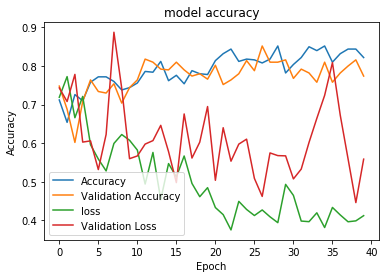

<Figure size 432x288 with 0 Axes>

In [36]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()
plt.savefig("Baseline_Model_10steps.png")